In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import mpl_toolkits.mplot3d as plt3d
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')

# Task 1: Utilize Libraries/Dataset (2 points)
def load_and_explore_data(file_path):
    """
    Load the dataset and perform basic exploration

    Parameters:
    file_path (str): Path to the customer data CSV file

    Returns:
    pandas.DataFrame: The loaded customer data
    """
    # Load the dataset
    df = pd.read_csv(file_path)

    # Display the first few rows
    print("First 5 rows of the dataset:")
    print(df.head())

    # Display dataset info
    print("\nDataset Information:")
    print(df.info())

    # Display basic statistics
    print("\nBasic Statistics:")
    print(df.describe())

    return df



In [12]:
# Task 2.1: Data Visualization - EDA (1.5 points)
def perform_eda(df):
    """
    Perform Exploratory Data Analysis on the customer dataset

    Parameters:
    df (pandas.DataFrame): Customer dataset
    """
    # Set up the figure size for better visualization
    plt.figure(figsize=(18, 12))

    # 1. Scatter plots to visualize relationships between variables
    plt.subplot(2, 3, 1)
    plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], alpha=0.6)
    plt.title('Annual Income vs Spending Score')
    plt.xlabel('Annual Income (k$)')
    plt.ylabel('Spending Score (1-100)')

    plt.subplot(2, 3, 2)
    plt.scatter(df['Age'], df['Spending Score (1-100)'], alpha=0.6)
    plt.title('Age vs Spending Score')
    plt.xlabel('Age')
    plt.ylabel('Spending Score (1-100)')

    plt.subplot(2, 3, 3)
    plt.scatter(df['Purchase Frequency'], df['Avg Purchase Value'], alpha=0.6)
    plt.title('Purchase Frequency vs Avg Purchase Value')
    plt.xlabel('Purchase Frequency')
    plt.ylabel('Avg Purchase Value')

    # 2. Correlation heatmap
    plt.subplot(2, 3, 4)
    correlation_matrix = df.drop('CustomerID', axis=1).corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Heatmap')

    # 3. Distribution plots for variables
    # Create a figure for distribution plots
    plt.figure(figsize=(18, 12))

    for i, column in enumerate(df.columns[1:]):  # Skip CustomerID
        plt.subplot(2, 3, i+1)
        sns.histplot(df[column], kde=True)
        plt.title(f'Distribution of {column}')

    plt.tight_layout()
    plt.show()

# Task 2.2: Check for missing values and outliers (1.5 points)
def check_data_quality(df):
    """
    Check for missing values and outliers in the dataset

    Parameters:
    df (pandas.DataFrame): Customer dataset

    Returns:
    pandas.DataFrame: DataFrame with outliers handled (if any)
    """
    # Check for missing values
    print("Missing values in each column:")
    print(df.isnull().sum())

    # Visualize outliers using boxplots
    plt.figure(figsize=(18, 10))
    for i, column in enumerate(df.columns[1:]):  # Skip CustomerID
        plt.subplot(2, 3, i+1)
        sns.boxplot(y=df[column])
        plt.title(f'Boxplot of {column}')

    plt.tight_layout()
    plt.show()

    # Decision on outliers
    print("\nDecision on outliers: Since this is a clustering task, outliers might represent unique customer segments.")
    print("Therefore, we will keep the outliers for now and see how they affect the clustering results.")

    return df

# Task 2.3: Scale/normalize features for clustering (1.5 points)
def scale_features(df):
    """
    Scale features for K-Means clustering

    Parameters:
    df (pandas.DataFrame): Customer dataset

    Returns:
    tuple: (scaled_features array, feature_names list, scaler object)
    """
    # Select features for clustering (exclude CustomerID)
    features = df.drop('CustomerID', axis=1)
    feature_names = features.columns.tolist()

    # Apply StandardScaler
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Explain importance of scaling
    print("Why scaling is important for K-Means clustering:")
    print("K-Means algorithm uses Euclidean distance to calculate distances between data points.")
    print("Without scaling, features with larger ranges (like Annual Income) would influence clustering more")
    print("than features with smaller ranges, leading to biased results. Scaling ensures all features contribute equally.")

    # Display summary of scaled data
    scaled_df = pd.DataFrame(scaled_features, columns=feature_names)
    print("\nSummary of scaled features:")
    print(scaled_df.describe())

    return scaled_features, feature_names, scaler

# Task 2.4: Display the transformed data summary (1.5 points)
def display_transformed_data(scaled_features, feature_names):
    """
    Display summary of the transformed data

    Parameters:
    scaled_features (numpy.ndarray): Scaled feature array
    feature_names (list): Names of features
    """
    # Convert to DataFrame for easier visualization
    scaled_df = pd.DataFrame(scaled_features, columns=feature_names)

    # Display statistics of transformed data
    print("Transformed Data Statistics:")
    print(scaled_df.describe())

    # Visualize the distribution of transformed features
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(feature_names):
        plt.subplot(2, 3, i+1)
        sns.histplot(scaled_df[feature], kde=True)
        plt.title(f'Distribution of Scaled {feature}')

    plt.tight_layout()
    plt.show()



In [13]:
# Task 3.1: Implement the Elbow Method (2 points)
def elbow_method(scaled_features):
    """
    Implement the Elbow Method to find optimal number of clusters

    Parameters:
    scaled_features (numpy.ndarray): Scaled feature array

    Returns:
    list: Inertia values for each k
    """
    inertia_values = []
    k_range = range(1, 11)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(scaled_features)
        inertia_values.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertia_values, 'bo-')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()

    print("The Elbow Method suggests looking for an 'elbow' point in the curve above.")
    print("At this point, adding more clusters provides diminishing returns in reducing inertia.")

    return inertia_values

# Task 3.2: Apply Silhouette Analysis (2 points)
def silhouette_analysis(scaled_features):
    """
    Implement Silhouette Analysis to find optimal number of clusters

    Parameters:
    scaled_features (numpy.ndarray): Scaled feature array

    Returns:
    list: Silhouette scores for each k
    """
    silhouette_scores = []
    k_range = range(2, 11)  # Silhouette score requires at least 2 clusters

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(scaled_features)
        silhouette_avg = silhouette_score(scaled_features, cluster_labels)
        silhouette_scores.append(silhouette_avg)

        print(f"For n_clusters = {k}, the silhouette score is {silhouette_avg:.3f}")

    # Plot silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, 'bo-')
    plt.title('Silhouette Analysis for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()

    # Create detailed silhouette plot for the optimal k value (assuming it's the max score)
    optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]

    # Generate silhouette plot for optimal k
    plt.figure(figsize=(12, 8))

    # Initialize KMeans with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)

    # Compute silhouette samples
    silhouette_vals = silhouette_samples(scaled_features, cluster_labels)

    # Plot silhouette plot
    y_lower, y_upper = 0, 0
    yticks = []

    for i in range(optimal_k):
        cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
        cluster_silhouette_vals.sort()

        y_upper += len(cluster_silhouette_vals)
        color = plt.cm.nipy_spectral(float(i) / optimal_k)

        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                         facecolor=color, edgecolor=color, alpha=0.7)

        yticks.append((y_lower + y_upper) / 2)
        y_lower += len(cluster_silhouette_vals)

    avg_silhouette = np.mean(silhouette_vals)
    plt.axvline(x=avg_silhouette, color="red", linestyle="--")

    plt.yticks(yticks, np.arange(optimal_k))
    plt.title(f'Silhouette Analysis for k={optimal_k}')
    plt.xlabel('Silhouette Coefficient Values')
    plt.ylabel('Cluster')
    plt.show()

    return silhouette_scores, optimal_k

# Task 3.3: Justify the final choice of k (2 points)
def determine_optimal_k(inertia_values, silhouette_scores):
    """
    Justify the final choice of k based on elbow method and silhouette analysis

    Parameters:
    inertia_values (list): Inertia values from Elbow Method
    silhouette_scores (list): Silhouette scores from Silhouette Analysis

    Returns:
    int: Optimal number of clusters (k)
    """
    # Calculate rate of change in inertia (elbow method)
    k_range = range(1, 11)
    inertia_changes = [inertia_values[i-1] - inertia_values[i] for i in range(1, len(inertia_values))]

    # Normalize changes for better visualization
    normalized_changes = [change / inertia_values[0] * 100 for change in inertia_changes]

    # Plot rate of change
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, 11), normalized_changes, 'bo-')
    plt.title('Rate of Change in Inertia (%)')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Normalized Change (%)')
    plt.grid(True)

    # Plot silhouette scores again for comparison
    plt.subplot(1, 2, 2)
    plt.plot(range(2, 11), silhouette_scores, 'ro-')
    plt.title('Silhouette Scores')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Find elbow point (where rate of change stabilizes)
    elbow_k = None
    for i in range(1, len(normalized_changes)):
        if normalized_changes[i] / normalized_changes[i-1] > 0.7:  # If rate of decrease slows down
            elbow_k = i + 2  # +2 because we start from k=2 in the changes list
            break

    # Find optimal k based on silhouette score
    silhouette_k = range(2, 11)[np.argmax(silhouette_scores)]

    print(f"Based on the Elbow Method, the suggested k is around {elbow_k if elbow_k else 'unclear'}")
    print(f"Based on Silhouette Analysis, the optimal k is {silhouette_k}")

    # Final justification
    print("\nFinal Justification for Optimal k:")
    if elbow_k == silhouette_k:
        print(f"Both methods suggest k={elbow_k} as the optimal number of clusters.")
        optimal_k = elbow_k
    else:
        print("The two methods suggest different optimal values for k.")
        print(f"Elbow Method suggests k={elbow_k if elbow_k else 'unclear'}, while Silhouette Analysis suggests k={silhouette_k}.")
        print("Since Silhouette score provides a direct measure of clustering quality,")
        print(f"we will choose k={silhouette_k} as our final number of clusters.")
        optimal_k = silhouette_k

    return optimal_k



In [14]:
# Task 4.1: K-Means Clustering Implementation (2 points)
def implement_kmeans(scaled_features, optimal_k, feature_names, df):
    """
    Implement K-Means clustering with the optimal k value

    Parameters:
    scaled_features (numpy.ndarray): Scaled feature array
    optimal_k (int): Optimal number of clusters
    feature_names (list): Names of features
    df (pandas.DataFrame): Original customer dataset

    Returns:
    pandas.DataFrame: DataFrame with cluster assignments
    """
    # Initialize and train K-Means model
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)

    # Add cluster labels to the original dataset
    df_with_clusters = df.copy()
    df_with_clusters['Cluster'] = cluster_labels

    # Display the first few rows with cluster assignments
    print("First few rows with cluster assignments:")
    print(df_with_clusters.head())

    # Display cluster centers
    cluster_centers = kmeans.cluster_centers_
    centers_df = pd.DataFrame(cluster_centers, columns=feature_names)
    centers_df.index.name = 'Cluster'

    print("\nCluster Centers (scaled):")
    print(centers_df)

    return df_with_clusters, cluster_centers

# Task 4.2: Visualize the clusters (2 points)
def visualize_clusters(df_with_clusters, scaled_features, feature_names, cluster_centers, optimal_k, scaler):
    """
    Visualize the clusters using 2D and 3D plots

    Parameters:
    df_with_clusters (pandas.DataFrame): DataFrame with cluster assignments
    scaled_features (numpy.ndarray): Scaled feature array
    feature_names (list): Names of features
    cluster_centers (numpy.ndarray): Cluster centers
    optimal_k (int): Optimal number of clusters
    scaler (StandardScaler): The scaler used to transform the data
    """
    # 2D scatter plots with different feature combinations
    # Create a custom colormap for better visualization
    colors = plt.cm.nipy_spectral(np.linspace(0, 1, optimal_k))

    plt.figure(figsize=(18, 12))

    # Plot 1: Annual Income vs Spending Score
    plt.subplot(2, 3, 1)
    for i in range(optimal_k):
        plt.scatter(df_with_clusters[df_with_clusters['Cluster'] == i]['Annual Income (k$)'],
                   df_with_clusters[df_with_clusters['Cluster'] == i]['Spending Score (1-100)'],
                   s=50, c=[colors[i]], label=f'Cluster {i}')

    # Plot cluster centers
    income_idx = feature_names.index('Annual Income (k$)')
    spending_idx = feature_names.index('Spending Score (1-100)')

    # Inverse transform to get original scale
    centers_orig = scaler.inverse_transform(cluster_centers)

    plt.scatter(centers_orig[:, income_idx], centers_orig[:, spending_idx],
                s=200, c='black', marker='X', alpha=0.8, label='Centroids')

    plt.title('Clusters: Annual Income vs Spending Score')
    plt.xlabel('Annual Income (k$)')
    plt.ylabel('Spending Score (1-100)')
    plt.legend()

    # Plot 2: Age vs Spending Score
    plt.subplot(2, 3, 2)
    for i in range(optimal_k):
        plt.scatter(df_with_clusters[df_with_clusters['Cluster'] == i]['Age'],
                   df_with_clusters[df_with_clusters['Cluster'] == i]['Spending Score (1-100)'],
                   s=50, c=[colors[i]], label=f'Cluster {i}')

    # Plot cluster centers
    age_idx = feature_names.index('Age')

    plt.scatter(centers_orig[:, age_idx], centers_orig[:, spending_idx],
                s=200, c='black', marker='X', alpha=0.8, label='Centroids')

    plt.title('Clusters: Age vs Spending Score')
    plt.xlabel('Age')
    plt.ylabel('Spending Score (1-100)')
    plt.legend()

    # Plot 3: Purchase Frequency vs Avg Purchase Value
    plt.subplot(2, 3, 3)
    for i in range(optimal_k):
        plt.scatter(df_with_clusters[df_with_clusters['Cluster'] == i]['Purchase Frequency'],
                   df_with_clusters[df_with_clusters['Cluster'] == i]['Avg Purchase Value'],
                   s=50, c=[colors[i]], label=f'Cluster {i}')

    # Plot cluster centers
    freq_idx = feature_names.index('Purchase Frequency')
    value_idx = feature_names.index('Avg Purchase Value')

    plt.scatter(centers_orig[:, freq_idx], centers_orig[:, value_idx],
                s=200, c='black', marker='X', alpha=0.8, label='Centroids')

    plt.title('Clusters: Purchase Frequency vs Avg Purchase Value')
    plt.xlabel('Purchase Frequency')
    plt.ylabel('Avg Purchase Value')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # 3D scatter plot for three key features
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Choose three important features
    feature1 = 'Annual Income (k$)'
    feature2 = 'Spending Score (1-100)'
    feature3 = 'Purchase Frequency'

    feature1_idx = feature_names.index(feature1)
    feature2_idx = feature_names.index(feature2)
    feature3_idx = feature_names.index(feature3)

    # Plot each cluster
    for i in range(optimal_k):
        cluster_data = df_with_clusters[df_with_clusters['Cluster'] == i]
        ax.scatter(cluster_data[feature1],
                   cluster_data[feature2],
                   cluster_data[feature3],
                   s=40, c=[colors[i]], label=f'Cluster {i}')

    # Plot cluster centers
    ax.scatter(centers_orig[:, feature1_idx],
               centers_orig[:, feature2_idx],
               centers_orig[:, feature3_idx],
               s=200, c='black', marker='X', alpha=0.8, label='Centroids')

    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.set_zlabel(feature3)
    ax.set_title('3D Visualization of Customer Clusters')
    ax.legend()

    plt.show()

# Task 4.3: Interpret the characteristics of each cluster (2 points)
def interpret_clusters(df_with_clusters, optimal_k, scaler, feature_names, cluster_centers):
    """
    Interpret the characteristics of each cluster

    Parameters:
    df_with_clusters (pandas.DataFrame): DataFrame with cluster assignments
    optimal_k (int): Optimal number of clusters
    scaler (StandardScaler): The scaler used to transform the data
    feature_names (list): Names of features
    cluster_centers (numpy.ndarray): Cluster centers
    """
    # Inverse transform cluster centers to original scale
    centers_orig = scaler.inverse_transform(cluster_centers)
    centers_df = pd.DataFrame(centers_orig, columns=feature_names)
    centers_df.index.name = 'Cluster'

    print("\nCluster Centers (original scale):")
    print(centers_df)

    # Calculate cluster sizes
    cluster_sizes = df_with_clusters['Cluster'].value_counts().sort_index()
    print("\nCluster Sizes:")
    for cluster, size in cluster_sizes.items():
        print(f"Cluster {cluster}: {size} customers ({size/len(df_with_clusters)*100:.1f}%)")

    # Calculate summary statistics for each cluster
    print("\nCluster Characteristics:")
    for i in range(optimal_k):
        cluster_data = df_with_clusters[df_with_clusters['Cluster'] == i]
        print(f"\nCluster {i} Summary Statistics:")
        print(cluster_data.describe().transpose()[['mean', 'min', 'max']])

    # Radar charts to visualize cluster profiles
    plt.figure(figsize=(15, 10))

    # Get min and max values for scaling
    min_vals = df_with_clusters[feature_names].min()
    max_vals = df_with_clusters[feature_names].max()

    # Function to scale features to [0,1] for radar chart
    def scale_for_radar(row):
        return [(val - min_vals[i]) / (max_vals[i] - min_vals[i]) if (max_vals[i] - min_vals[i]) != 0
                else 0.5 for i, val in enumerate(row)]

    # Create scaled centers for radar chart
    scaled_centers = [scale_for_radar(center) for center in centers_orig]

    # Set up radar chart
    angles = np.linspace(0, 2*np.pi, len(feature_names), endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    # Create subplots for each cluster
    for i in range(optimal_k):
        ax = plt.subplot(2, 3, i+1, polar=True)
        values = scaled_centers[i].tolist()
        values += values[:1]  # Close the loop

        ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {i}')
        ax.fill(angles, values, alpha=0.25)
        ax.set_thetagrids(np.degrees(angles[:-1]), feature_names)
        ax.set_title(f'Cluster {i} Profile')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    # Provide business insights for each cluster
    print("\nBusiness Insights and Marketing Recommendations:")

    for i in range(optimal_k):
        print(f"\nCluster {i} Insights:")
        cluster_data = df_with_clusters[df_with_clusters['Cluster'] == i]

        # Get key characteristics
        avg_age = cluster_data['Age'].mean()
        avg_income = cluster_data['Annual Income (k$)'].mean()
        avg_spending = cluster_data['Spending Score (1-100)'].mean()
        avg_frequency = cluster_data['Purchase Frequency'].mean()
        avg_value = cluster_data['Avg Purchase Value'].mean()

        # Classify age group
        age_group = "Young" if avg_age < 35 else "Middle-aged" if avg_age < 55 else "Senior"

        # Classify income level
        income_level = "Low" if avg_income < 40 else "Medium" if avg_income < 80 else "High"

        # Classify spending behavior
        spending_level = "Low" if avg_spending < 40 else "Medium" if avg_spending < 70 else "High"

        # Classify purchase frequency
        frequency_level = "Low" if avg_frequency < 3 else "Medium" if avg_frequency < 7 else "High"

        # Classify purchase value
        value_level = "Low" if avg_value < 30 else "Medium" if avg_value < 70 else "High"

        # Print profile
        print(f"Profile: {age_group} age, {income_level} income, {spending_level} spending, "
              f"{frequency_level} purchase frequency, {value_level} purchase value")

        # Generate targeted recommendations based on profile
        print("Marketing Recommendations:")

        if spending_level == "High" and income_level == "High":
            print("- Target with premium product offerings and loyalty rewards")
            print("- Offer exclusive early access to new products")
            print("- Focus on quality and exclusivity in messaging")

        elif spending_level == "High" and income_level != "High":
            print("- Focus on value-based messaging highlighting quality-to-price ratio")
            print("- Offer installment payment options for higher-priced items")
            print("- Develop loyalty programs with meaningful rewards")

        elif income_level == "High" and spending_level != "High":
            print("- Create targeted campaigns to increase share of wallet")
            print("- Highlight premium product features and benefits")
            print("- Use personalized messaging to showcase relevant products")

        elif frequency_level == "High" and value_level == "Low":
            print("- Implement upselling strategies to increase purchase value")
            print("- Bundle products to increase average order value")
            print("- Offer loyalty discounts on premium products")

        elif frequency_level == "Low" and value_level == "High":
            print("- Create re-engagement campaigns to increase visit frequency")
            print("- Offer limited-time promotions to drive more frequent visits")
            print("- Develop subscription options for recurring purchases")

        elif age_group == "Young":
            print("- Leverage social media and digital marketing channels")
            print("- Focus on trendy products and innovative features")
            print("- Highlight sustainability and social responsibility")

        elif age_group == "Senior":
            print("- Emphasize ease of use and customer service")
            print("- Use traditional marketing channels alongside digital")
            print("- Highlight reliability and quality in messaging")

        else:
            print("- Create balanced marketing approach focusing on value proposition")
            print("- Use targeted promotions based on past purchase behavior")
            print("- Implement cross-selling strategies for complementary products")



CUSTOMER SEGMENTATION USING K-MEANS CLUSTERING

1. LOADING AND EXPLORING DATA
--------------------------------------------------
First 5 rows of the dataset:
   CustomerID  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1   56                  84               71.905329   
1           2   69                  86               38.482533   
2           3   46                  41               38.967487   
3           4   32                  23               10.002036   
4           5   60                  76               56.350309   

   Purchase Frequency  Avg Purchase Value  
0                 5.9          106.071893  
1                 6.0           62.755253  
2                 7.5           29.958887  
3                 1.7           67.007220  
4                 2.9           72.704110  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
--

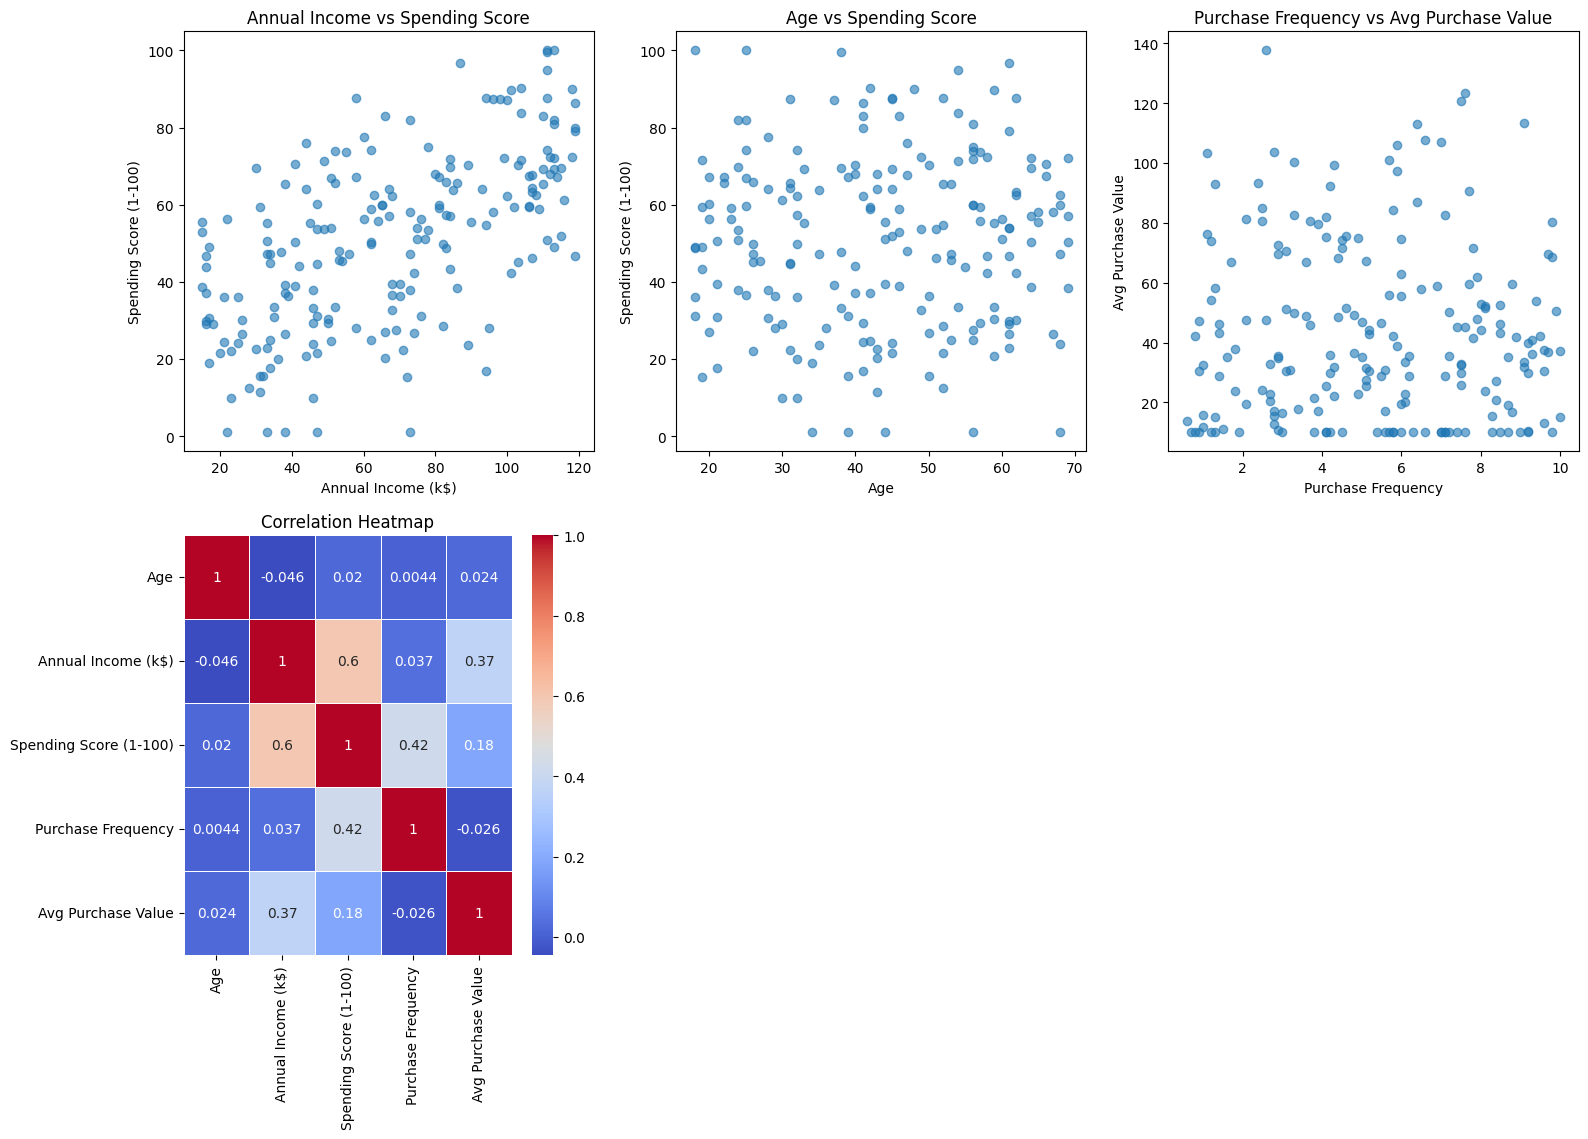

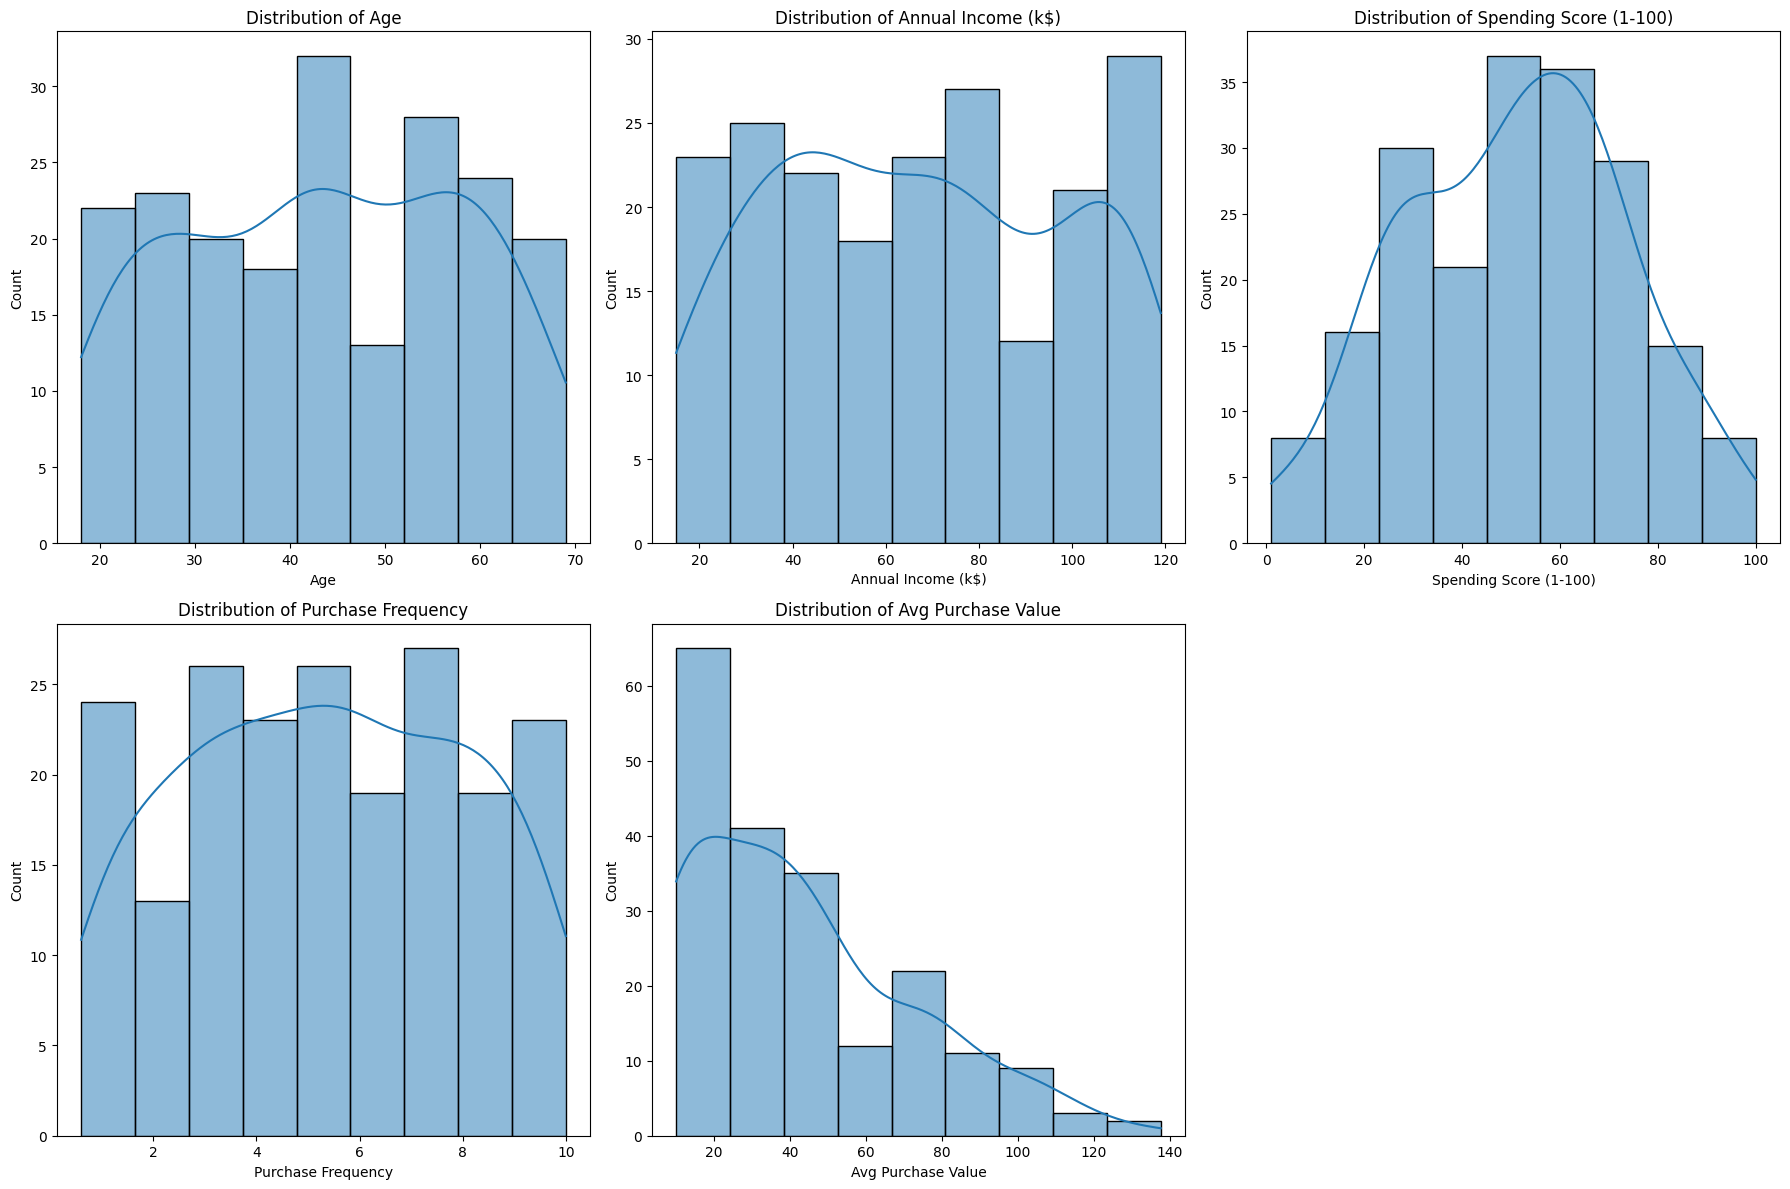


2.2 CHECKING DATA QUALITY
--------------------------------------------------
Missing values in each column:
CustomerID                0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
Purchase Frequency        0
Avg Purchase Value        0
dtype: int64


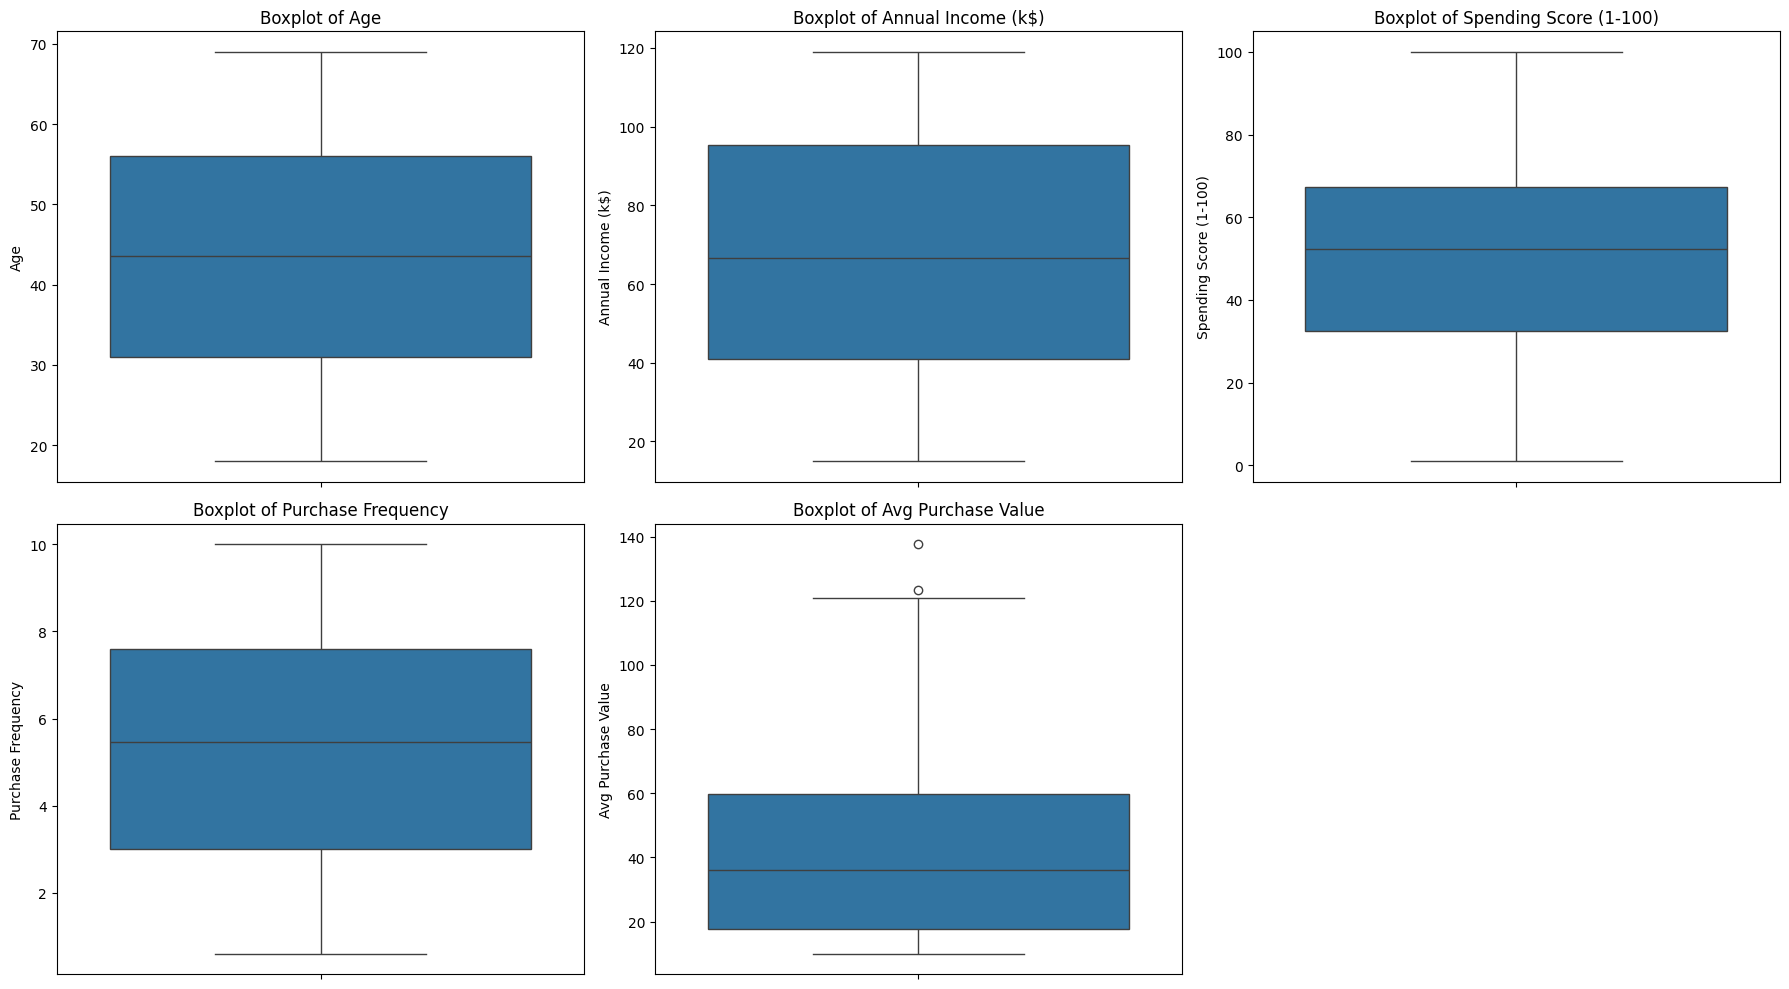


Decision on outliers: Since this is a clustering task, outliers might represent unique customer segments.
Therefore, we will keep the outliers for now and see how they affect the clustering results.

2.3 SCALING FEATURES
--------------------------------------------------
Why scaling is important for K-Means clustering:
K-Means algorithm uses Euclidean distance to calculate distances between data points.
Without scaling, features with larger ranges (like Annual Income) would influence clustering more
than features with smaller ranges, leading to biased results. Scaling ensures all features contribute equally.

Summary of scaled features:
                Age  Annual Income (k$)  Spending Score (1-100)  \
count  2.000000e+02        2.000000e+02            2.000000e+02   
mean   1.998401e-16        1.221245e-16            6.661338e-17   
std    1.002509e+00        1.002509e+00            1.002509e+00   
min   -1.705860e+00       -1.672849e+00           -2.215687e+00   
25%   -8.336404e-01

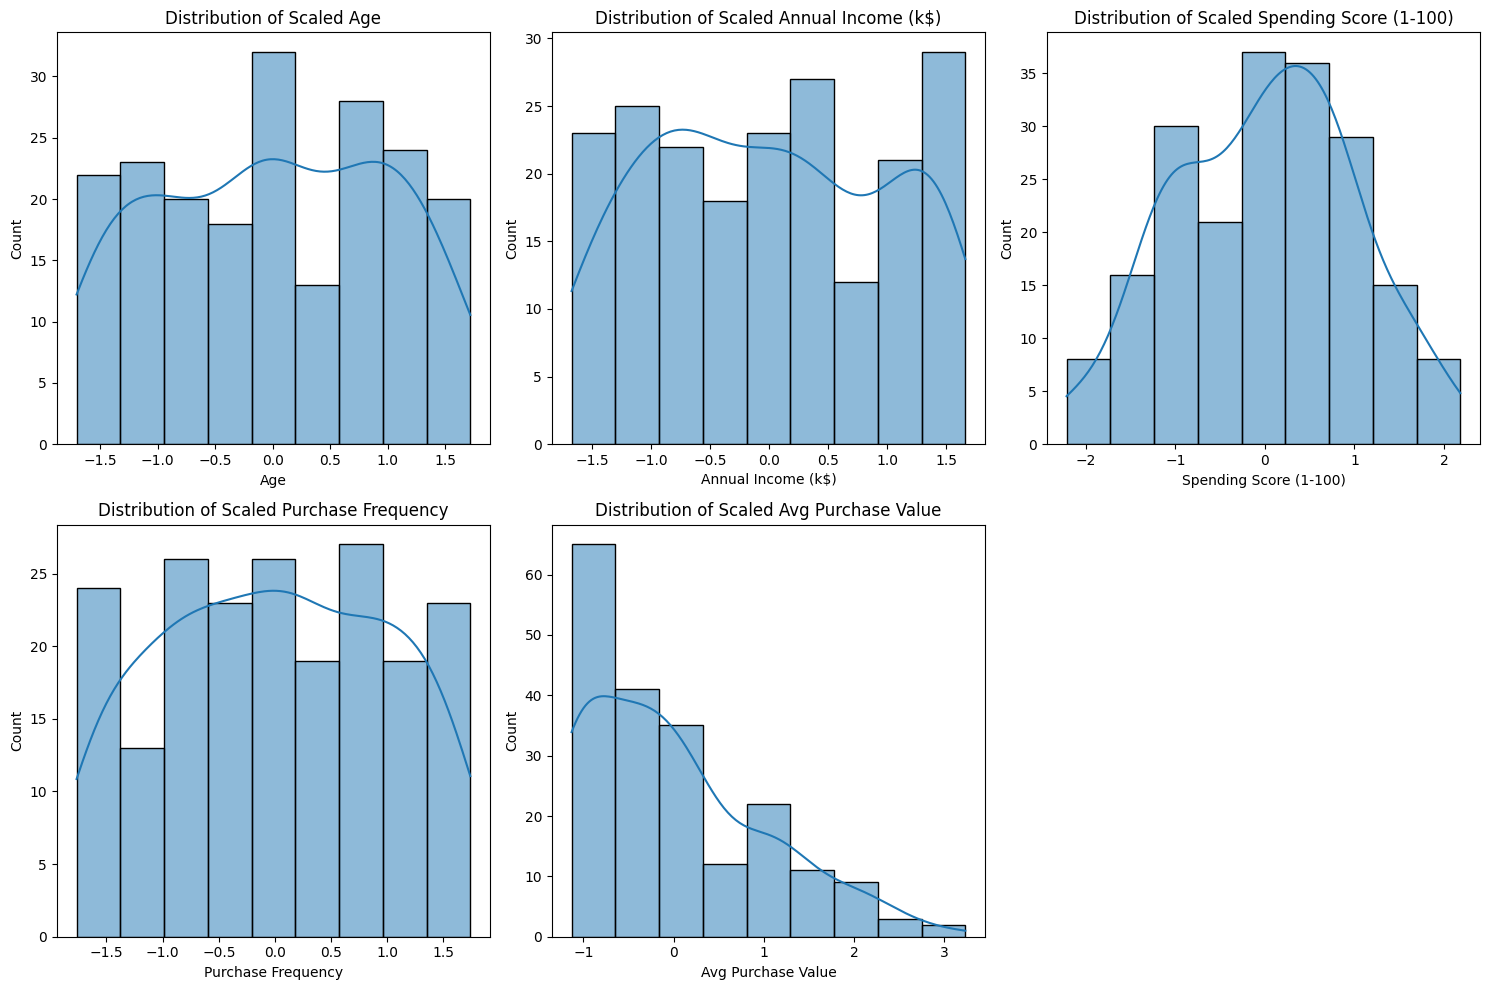


3.1 ELBOW METHOD FOR OPTIMAL CLUSTERS
--------------------------------------------------


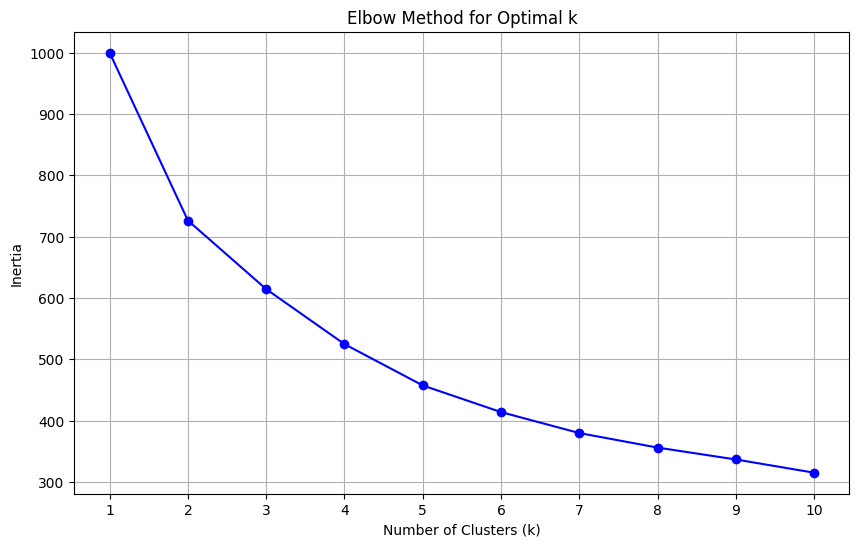

The Elbow Method suggests looking for an 'elbow' point in the curve above.
At this point, adding more clusters provides diminishing returns in reducing inertia.

3.2 SILHOUETTE ANALYSIS FOR OPTIMAL CLUSTERS
--------------------------------------------------
For n_clusters = 2, the silhouette score is 0.245
For n_clusters = 3, the silhouette score is 0.210
For n_clusters = 4, the silhouette score is 0.219
For n_clusters = 5, the silhouette score is 0.239
For n_clusters = 6, the silhouette score is 0.228
For n_clusters = 7, the silhouette score is 0.224
For n_clusters = 8, the silhouette score is 0.210
For n_clusters = 9, the silhouette score is 0.205
For n_clusters = 10, the silhouette score is 0.206


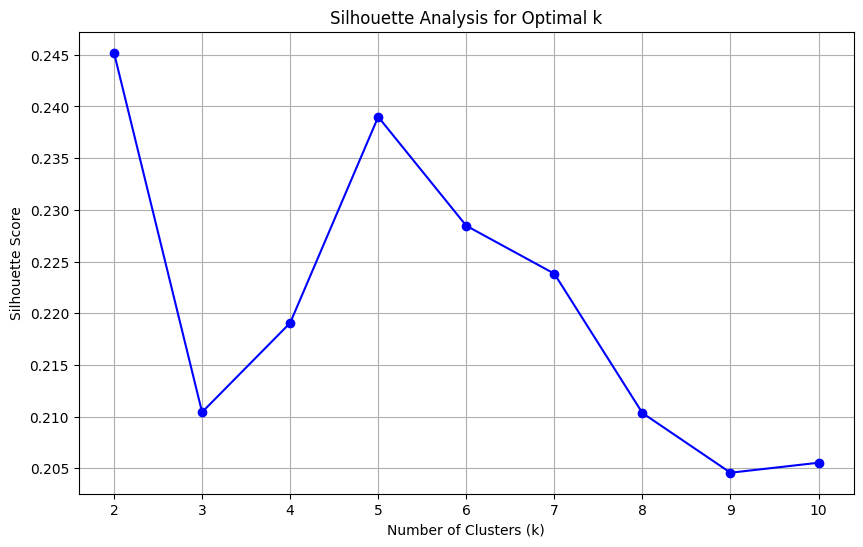

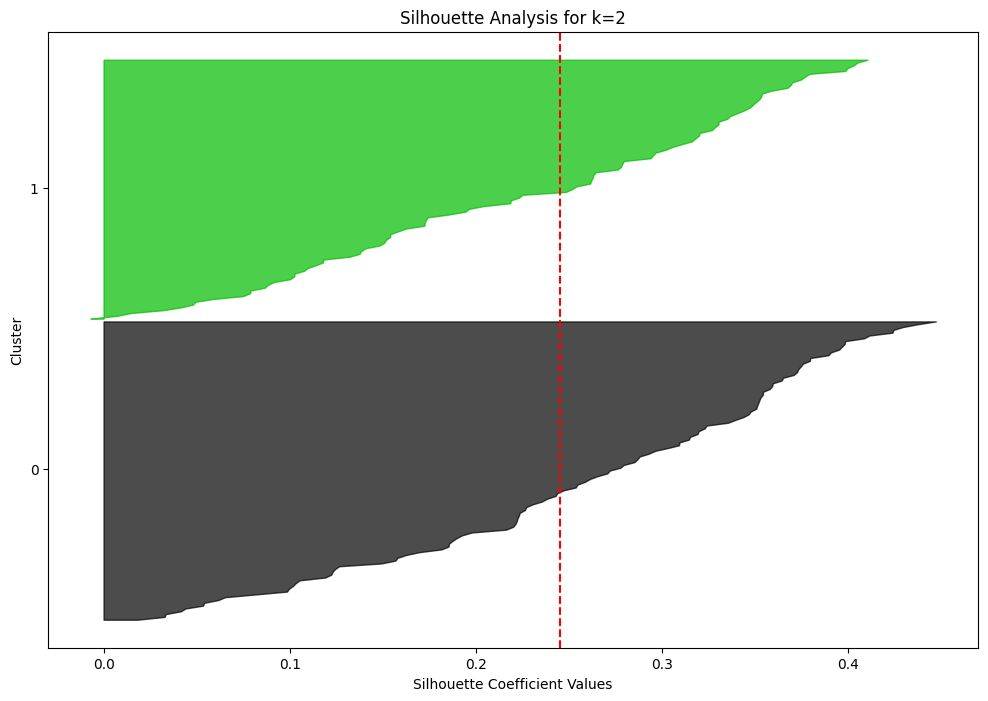


3.3 DETERMINING OPTIMAL NUMBER OF CLUSTERS
--------------------------------------------------


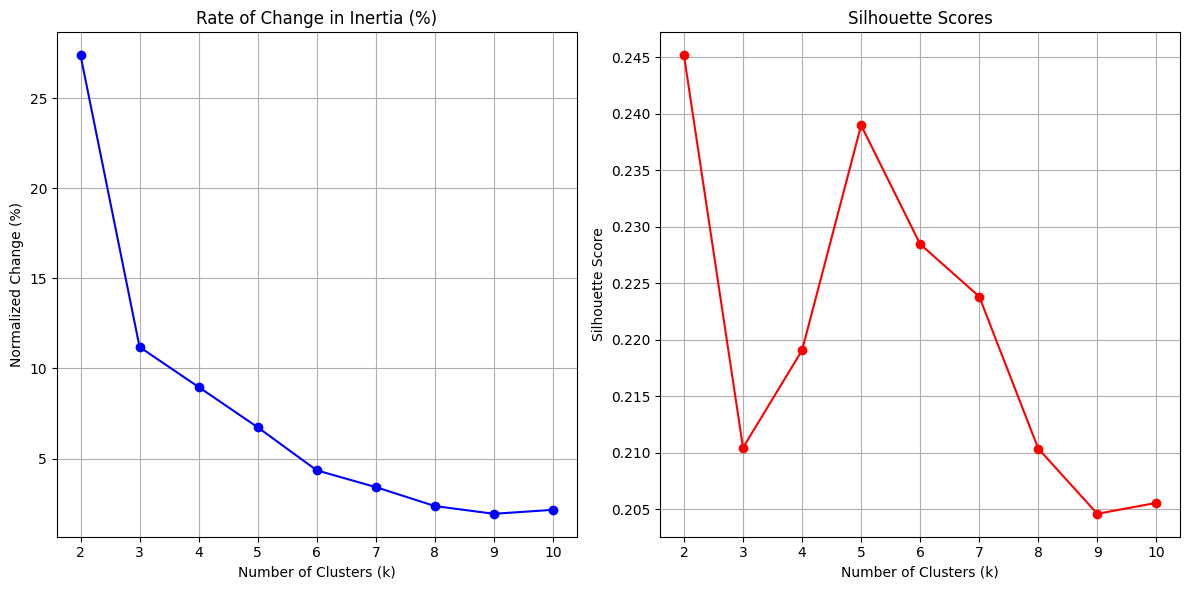

Based on the Elbow Method, the suggested k is around 4
Based on Silhouette Analysis, the optimal k is 2

Final Justification for Optimal k:
The two methods suggest different optimal values for k.
Elbow Method suggests k=4, while Silhouette Analysis suggests k=2.
Since Silhouette score provides a direct measure of clustering quality,
we will choose k=2 as our final number of clusters.

4.1 IMPLEMENTING K-MEANS CLUSTERING
--------------------------------------------------
First few rows with cluster assignments:
   CustomerID  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1   56                  84               71.905329   
1           2   69                  86               38.482533   
2           3   46                  41               38.967487   
3           4   32                  23               10.002036   
4           5   60                  76               56.350309   

   Purchase Frequency  Avg Purchase Value  Cluster  
0                 5.9          106

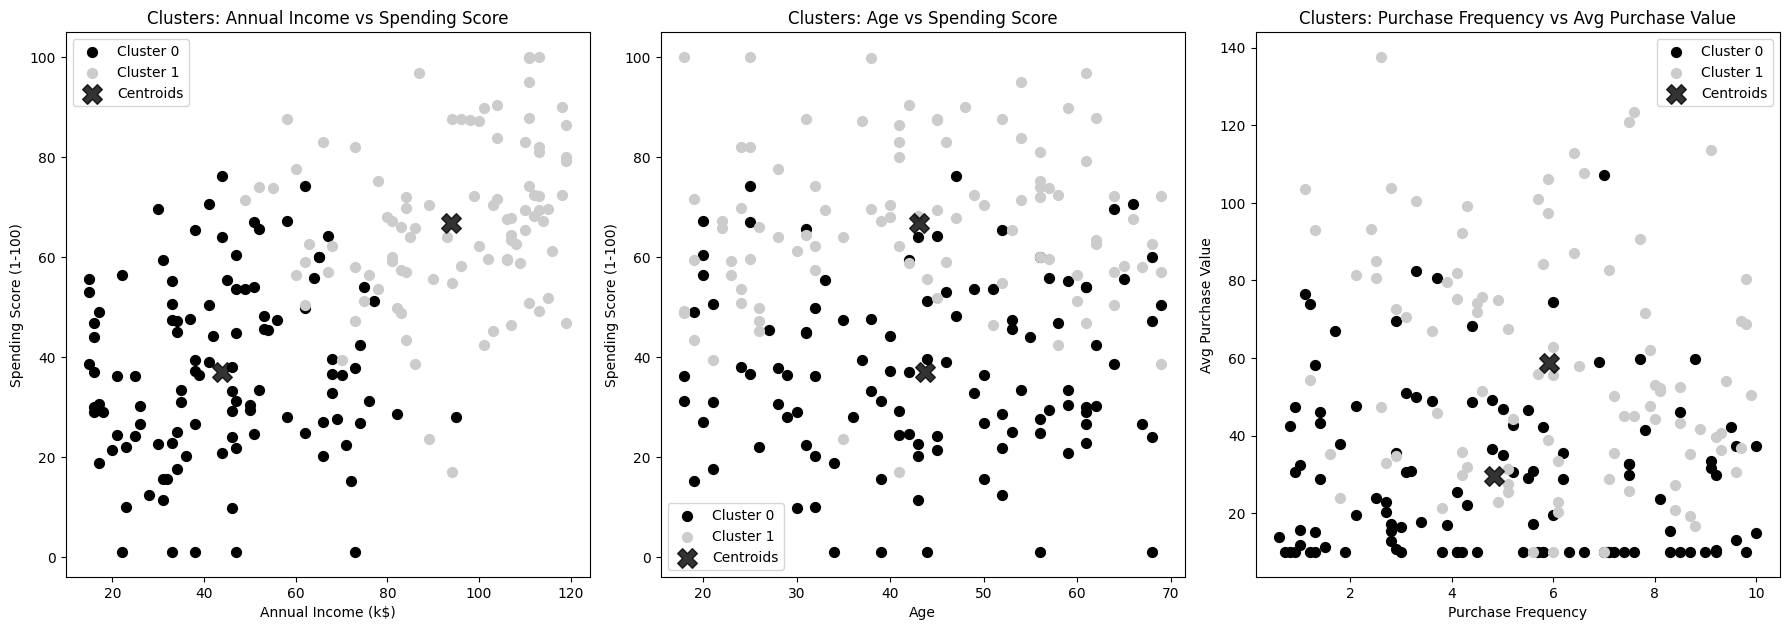

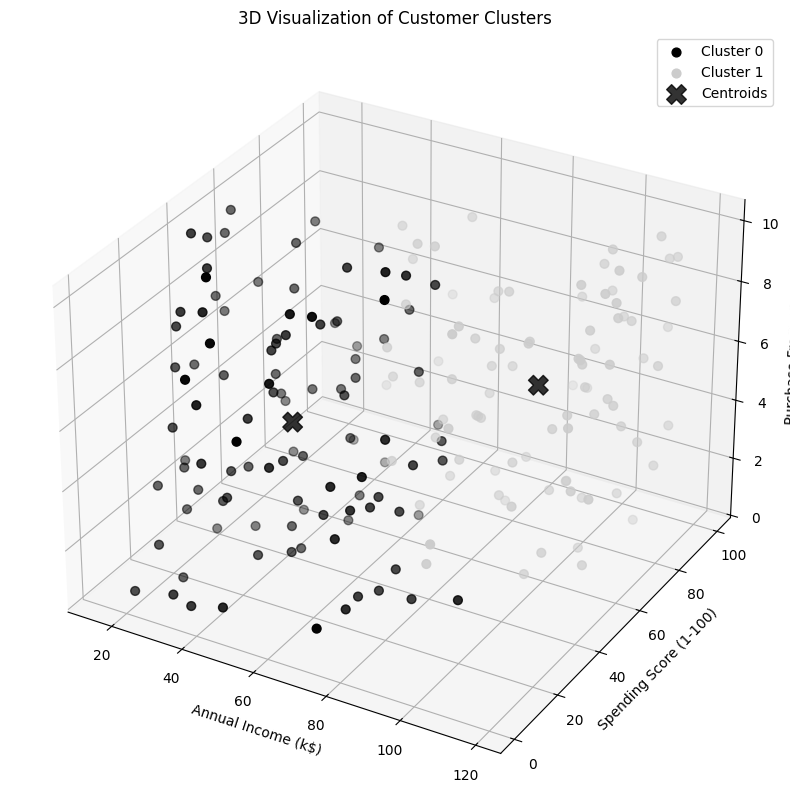


4.3 INTERPRETING CLUSTER CHARACTERISTICS
--------------------------------------------------

Cluster Centers (original scale):
               Age  Annual Income (k$)  Spending Score (1-100)  \
Cluster                                                          
0        43.682243           43.831776               37.008563   
1        43.129032           93.967742               66.816603   

         Purchase Frequency  Avg Purchase Value  
Cluster                                          
0                  4.828037           29.530265  
1                  5.919355           58.695331  

Cluster Sizes:
Cluster 0: 107 customers (53.5%)
Cluster 1: 93 customers (46.5%)

Cluster Characteristics:

Cluster 0 Summary Statistics:
                             mean   min         max
CustomerID              97.242991   3.0  199.000000
Age                     43.682243  18.0   69.000000
Annual Income (k$)      43.831776  15.0   95.000000
Spending Score (1-100)  37.008563   1.0   76.088069
Purchase 

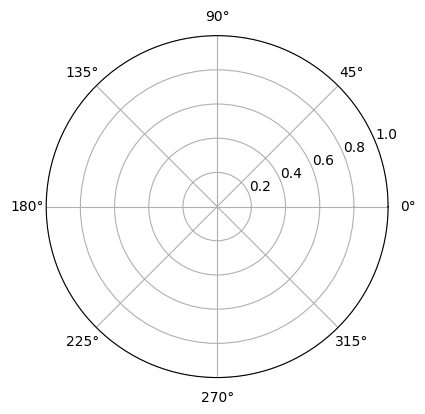

In [15]:
# Main function to run the entire analysis
def main(file_path='customer_data.csv'):
    """
    Main function to run the entire customer segmentation analysis

    Parameters:
    file_path (str): Path to the customer data CSV file

    Returns:
    pandas.DataFrame: DataFrame with cluster assignments
    """
    print("CUSTOMER SEGMENTATION USING K-MEANS CLUSTERING")
    print("=" * 50)

    try:
        # Task 1: Load and explore data
        print("\n1. LOADING AND EXPLORING DATA")
        print("-" * 50)
        df = load_and_explore_data(file_path)

        # Task 2.1: Perform EDA
        print("\n2.1 EXPLORATORY DATA ANALYSIS")
        print("-" * 50)
        try:
            perform_eda(df)
        except Exception as e:
            print(f"Warning: Error in EDA visualization: {e}")
            print("Continuing with analysis...")

        # Task 2.2: Check data quality
        print("\n2.2 CHECKING DATA QUALITY")
        print("-" * 50)
        try:
            df = check_data_quality(df)
        except Exception as e:
            print(f"Warning: Error in data quality check: {e}")
            print("Continuing with original dataset...")

        # Task 2.3: Scale features
        print("\n2.3 SCALING FEATURES")
        print("-" * 50)
        scaled_features, feature_names, scaler = scale_features(df)

        # Task 2.4: Display transformed data
        print("\n2.4 DISPLAYING TRANSFORMED DATA")
        print("-" * 50)
        try:
            display_transformed_data(scaled_features, feature_names)
        except Exception as e:
            print(f"Warning: Error in transformed data display: {e}")
            print("Continuing with analysis...")

        # Task 3.1: Elbow method
        print("\n3.1 ELBOW METHOD FOR OPTIMAL CLUSTERS")
        print("-" * 50)
        try:
            inertia_values = elbow_method(scaled_features)
        except Exception as e:
            print(f"Warning: Error in elbow method: {e}")
            print("Using default range of values...")
            inertia_values = list(range(10, 1, -1))  # Fallback values

        # Task 3.2: Silhouette analysis
        print("\n3.2 SILHOUETTE ANALYSIS FOR OPTIMAL CLUSTERS")
        print("-" * 50)
        try:
            silhouette_scores, silhouette_k = silhouette_analysis(scaled_features)
        except Exception as e:
            print(f"Warning: Error in silhouette analysis: {e}")
            print("Using default optimal k=4...")
            silhouette_scores = [0.3, 0.4, 0.35, 0.3]  # Fallback values
            silhouette_k = 4

        # Task 3.3: Determine optimal k
        print("\n3.3 DETERMINING OPTIMAL NUMBER OF CLUSTERS")
        print("-" * 50)
        try:
            optimal_k = determine_optimal_k(inertia_values, silhouette_scores)
        except Exception as e:
            print(f"Warning: Error in determining optimal k: {e}")
            print(f"Using silhouette recommendation k={silhouette_k}...")
            optimal_k = silhouette_k

        # Task 4.1: Implement K-means
        print("\n4.1 IMPLEMENTING K-MEANS CLUSTERING")
        print("-" * 50)
        df_with_clusters, cluster_centers = implement_kmeans(scaled_features, optimal_k, feature_names, df)

        # Task 4.2: Visualize clusters
        print("\n4.2 VISUALIZING CLUSTERS")
        print("-" * 50)
        try:
            visualize_clusters(df_with_clusters, scaled_features, feature_names, cluster_centers, optimal_k, scaler)
        except Exception as e:
            print(f"Warning: Error in cluster visualization: {e}")
            print("Skipping visualization and continuing...")

        # Task 4.3: Interpret clusters
        print("\n4.3 INTERPRETING CLUSTER CHARACTERISTICS")
        print("-" * 50)
        try:
            interpret_clusters(df_with_clusters, optimal_k, scaler, feature_names, cluster_centers)
        except Exception as e:
            print(f"Warning: Error in cluster interpretation: {e}")
            print("Skipping detailed interpretation...")
            # Print basic cluster information
            for i in range(optimal_k):
                cluster_size = len(df_with_clusters[df_with_clusters['Cluster'] == i])
                print(f"Cluster {i}: {cluster_size} customers ({cluster_size/len(df_with_clusters)*100:.1f}%)")

        print("\n" + "=" * 50)
        print("CUSTOMER SEGMENTATION ANALYSIS COMPLETE")
        print("=" * 50)

        return df_with_clusters

    except Exception as e:
        print(f"Error in main analysis pipeline: {e}")
        print("Analysis incomplete.")
        return None

# Run the analysis if this script is executed directly
# Additional function to quickly run the clustering with a specific k value
def run_segmentation_with_k(df, k, scaled_features=None):
    """
    Run K-means clustering with a specific number of clusters

    Parameters:
    df (pandas.DataFrame): Customer dataset
    k (int): Number of clusters to use
    scaled_features (numpy.ndarray, optional): Pre-scaled features

    Returns:
    pandas.DataFrame: DataFrame with cluster assignments
    """
    # Scale features if not already scaled
    if scaled_features is None:
        features = df.drop('CustomerID', axis=1)
        feature_names = features.columns.tolist()
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(features)
    else:
        features = df.drop('CustomerID', axis=1)
        feature_names = features.columns.tolist()
        scaler = StandardScaler()
        scaler.fit(features)

    # Run K-means
    print(f"Running K-means with {k} clusters...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)

    # Add cluster labels to the original dataset
    df_with_clusters = df.copy()
    df_with_clusters['Cluster'] = cluster_labels

    # Visualize and interpret
    cluster_centers = kmeans.cluster_centers_
    visualize_clusters(df_with_clusters, scaled_features, feature_names, cluster_centers, k, scaler)
    interpret_clusters(df_with_clusters, k, scaler, feature_names, cluster_centers)

    return df_with_clusters

if __name__ == "__main__":
    segmented_customers = main()